In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import math
import os

from datetime import datetime
from scipy.ndimage import *
from scipy.fftpack import *

# below is mainly for autotime assertion warnings
import warnings
warnings.filterwarnings("ignore")

%load_ext autotime
%matplotlib inline

FILE = "cleaned_data.csv"
DIRI = "processed_data"

%pwd

'C:\\Users\\jimpg\\OneDrive\\Documents\\APWS\\jupyter'

In [2]:
file_path = os.path.join("..", DIRI, FILE)
df = pd.read_csv(file_path)
df

,Unnamed: 0,Temperature (K),Radiation,SO2,NO2,O3,CO,PM10,PM2.5
0,2017-01-01 00:00:00,272.00818,61.362255,0.004,0.059,0.002,1.2,73.0,57.0
1,2017-01-01 01:00:00,272.25480,171.832320,0.004,0.058,0.002,1.2,71.0,59.0
2,2017-01-01 02:00:00,277.65262,299.281650,0.004,0.056,0.002,1.2,70.0,59.0
3,2017-01-01 03:00:00,278.54010,390.387570,0.004,0.056,0.002,1.2,70.0,58.0
4,2017-01-01 04:00:00,278.69528,378.793100,0.003,0.051,0.002,1.2,69.0,61.0
...,...,...,...,...,...,...,...,...,...
25900,2019-12-31 19:00:00,267.61273,0.000000,0.003,0.026,0.014,0.5,26.0,19.0
25901,2019-12-31 20:00:00,268.24185,0.000000,0.003,0.024,0.014,0.4,27.0,19.0
25902,2019-12-31 21:00:00,268.46835,0.000000,0.003,0.014,0.021,0.4,23.0,18.0
25903,2019-12-31 22:00:00,268.89783,0.000000,0.003,0.022,0.014,0.5,20.0,19.0


time: 46.7 ms


In [3]:
print(df.columns)
df.rename(columns = {'Unnamed: 0':'Time'}, inplace = True)
df

Index(['Unnamed: 0', 'Temperature (K)', 'Radiation', 'SO2', 'NO2', 'O3', 'CO',
       'PM10', 'PM2.5'],
      dtype='object')


,Time,Temperature (K),Radiation,SO2,NO2,O3,CO,PM10,PM2.5
0,2017-01-01 00:00:00,272.00818,61.362255,0.004,0.059,0.002,1.2,73.0,57.0
1,2017-01-01 01:00:00,272.25480,171.832320,0.004,0.058,0.002,1.2,71.0,59.0
2,2017-01-01 02:00:00,277.65262,299.281650,0.004,0.056,0.002,1.2,70.0,59.0
3,2017-01-01 03:00:00,278.54010,390.387570,0.004,0.056,0.002,1.2,70.0,58.0
4,2017-01-01 04:00:00,278.69528,378.793100,0.003,0.051,0.002,1.2,69.0,61.0
...,...,...,...,...,...,...,...,...,...
25900,2019-12-31 19:00:00,267.61273,0.000000,0.003,0.026,0.014,0.5,26.0,19.0
25901,2019-12-31 20:00:00,268.24185,0.000000,0.003,0.024,0.014,0.4,27.0,19.0
25902,2019-12-31 21:00:00,268.46835,0.000000,0.003,0.014,0.021,0.4,23.0,18.0
25903,2019-12-31 22:00:00,268.89783,0.000000,0.003,0.022,0.014,0.5,20.0,19.0


time: 12 ms


# Exploratory Data Analysis
### Topics of Interest:
- Trends
- Correlations
- Fourier Transformations
- Feature Importance
- Possible Clustering

### Questions of Interest:
- What frequencies have the greatest power for air pollution time series?
- What is the relation of air pollution concentrations to temperatures (raw, [min, max, mean] on different time scales)?
- What is the relation of air pollution concentrations to radiation (raw, [min, max, mean] on different time scales)?
- For the above weather values (raw, [min, max, mean] on different time scales), how do air pollutant concentrations relate to the quantiles of these values (eg. for 90th percentile max air temperature, what are concentrations like)?
- What features are most important for the prediction of air pollutant concentrations?
- Can data inouts be clustered to improve future machine learning models?

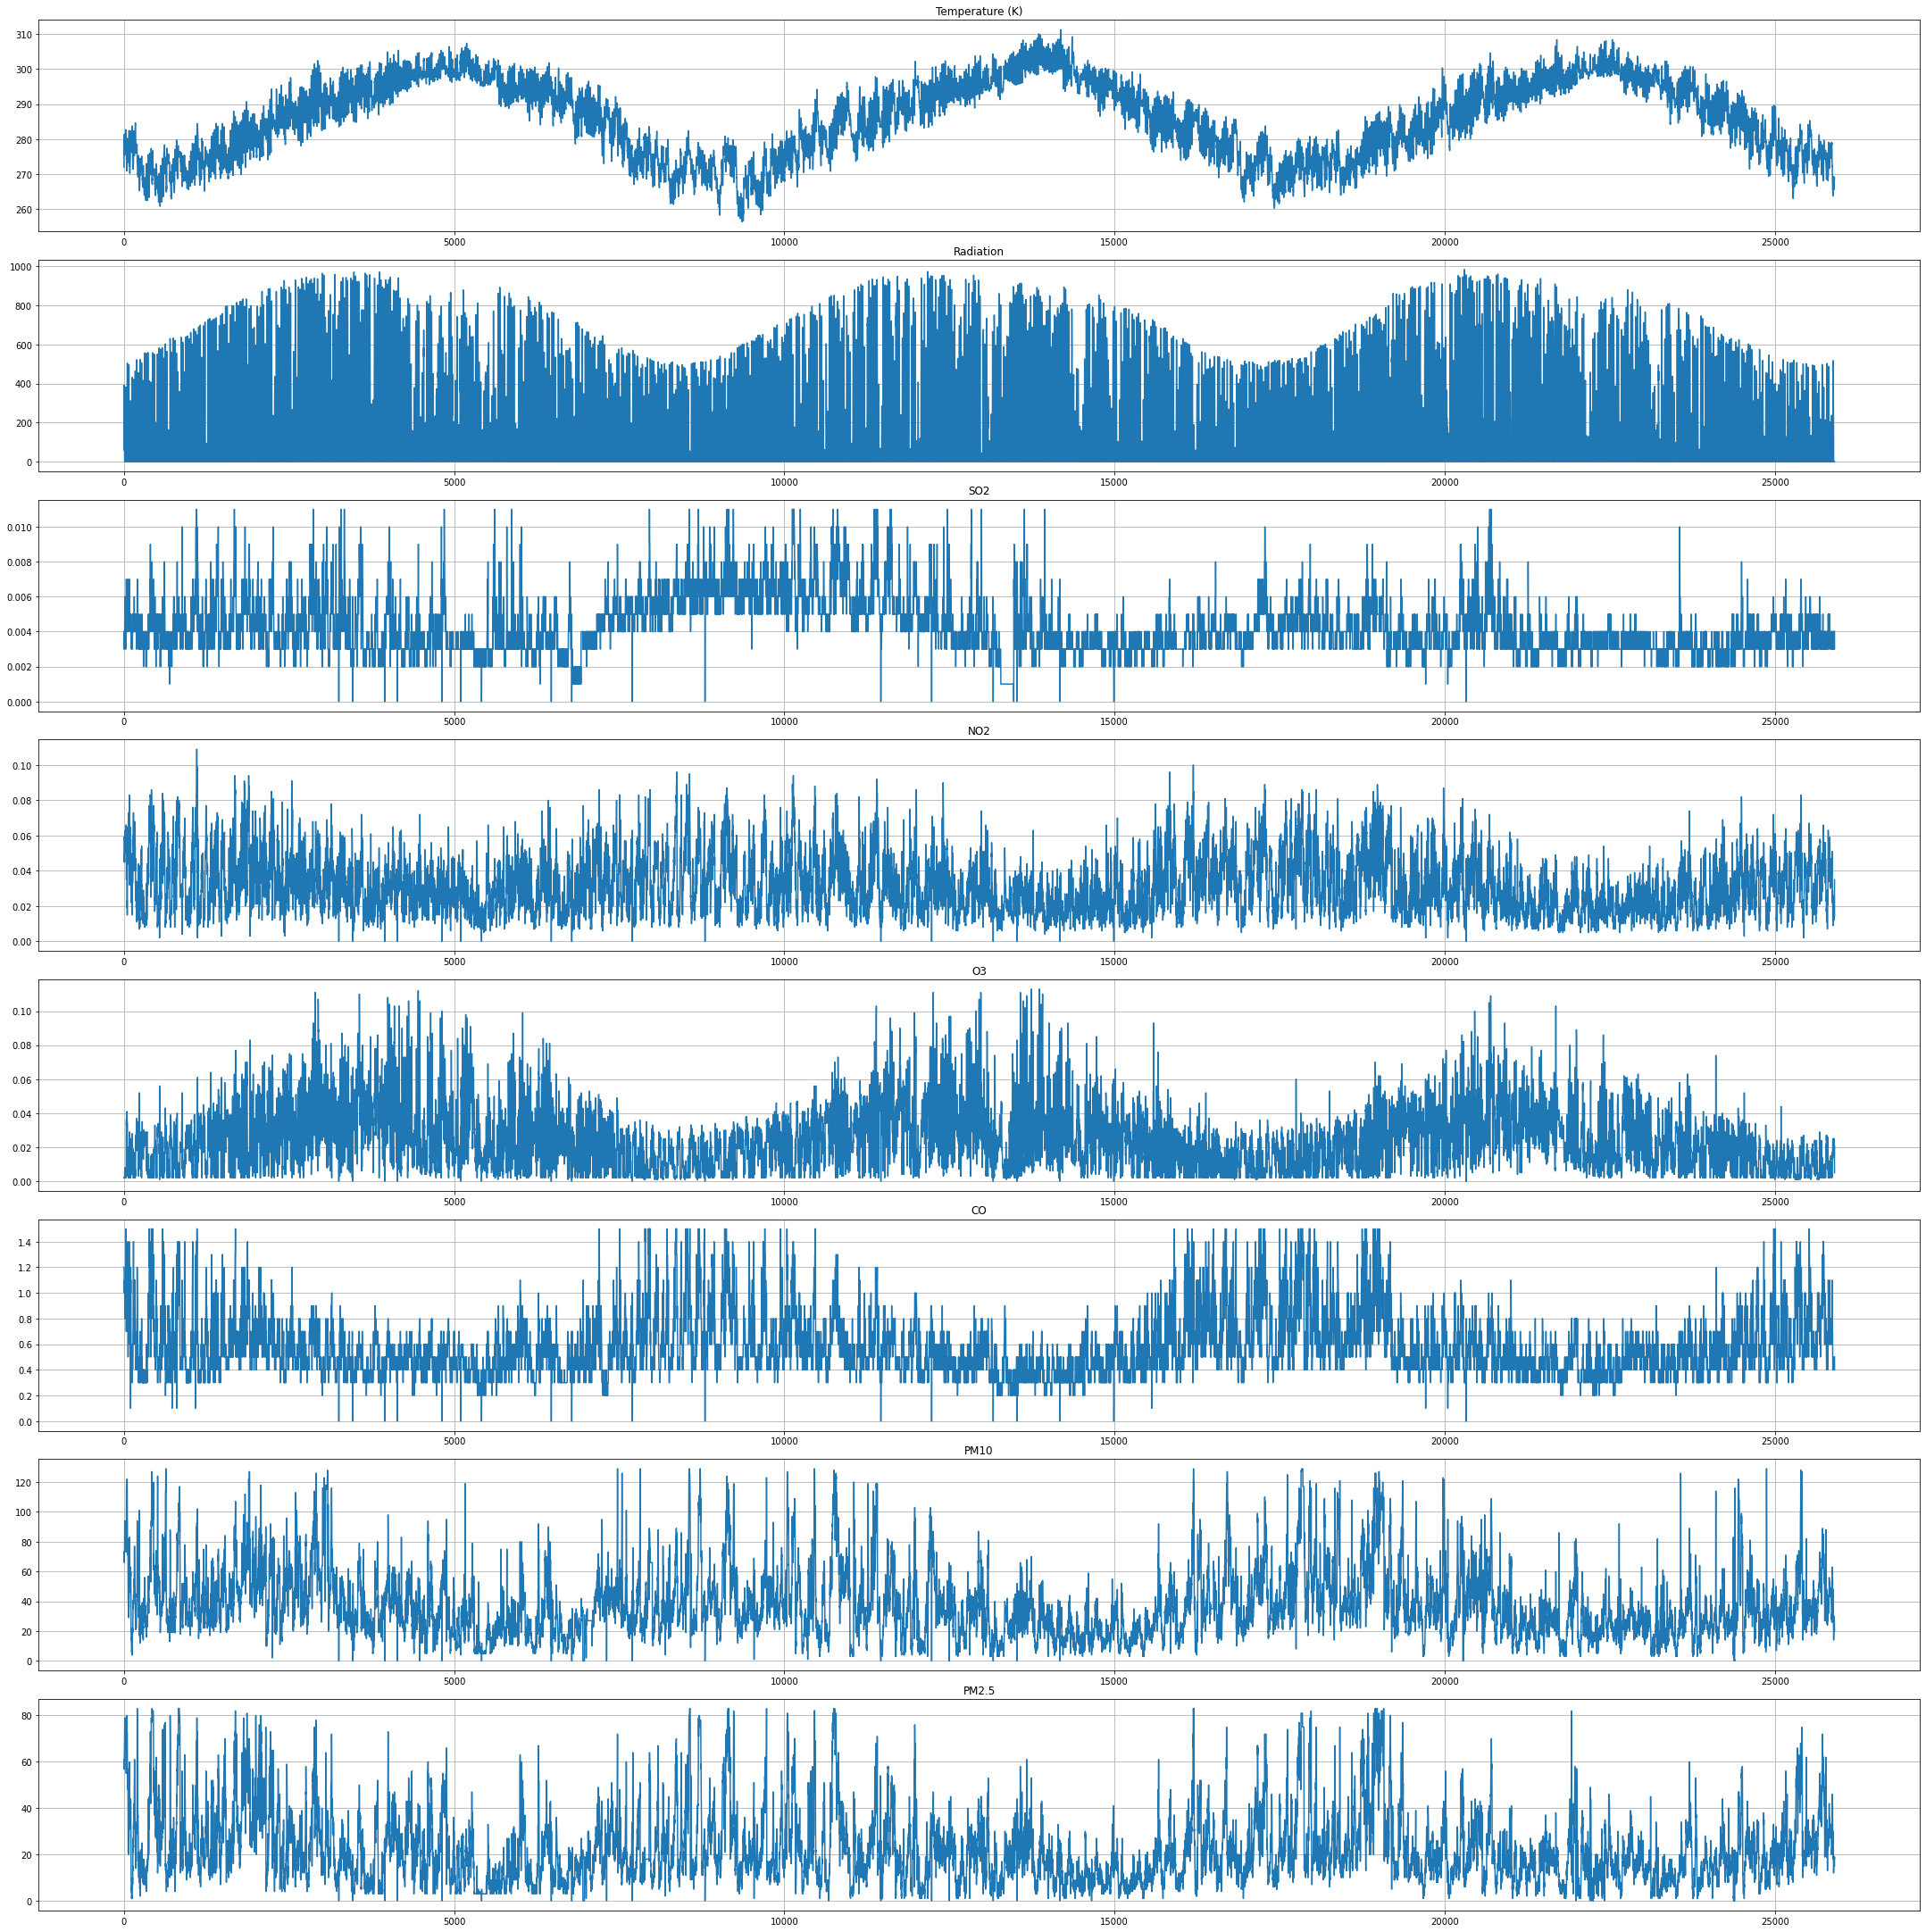

time: 969 ms


In [4]:
components = ['Temperature (K)', 'Radiation', 'SO2', 'NO2', 'O3', 'CO', 'PM10', 'PM2.5']

fig, axs = plt.subplots(8,1, figsize = (30, 30))
fig.tight_layout()

for idx, item in enumerate(components):
    axs[idx].plot(df[item]); plt.grid()
    axs[idx].set_title(item); axs[idx].grid()

### Trends


Temperature (K) parameters:
 const    284.142912
x1         0.000121
dtype: float64
Regression Start:  284.1429119404823 
Regression End:  287.27767578544143

Radiation parameters:
 const    191.605839
x1        -0.001073
dtype: float64
Regression Start:  191.60583865375122 
Regression End:  163.8166061264621

SO2 parameters:
 const    4.808495e-03
x1      -4.472461e-08
dtype: float64
Regression Start:  0.004808495322710897 
Regression End:  0.0036499489930582416

NO2 parameters:
 const    3.490243e-02
x1      -2.528553e-07
dtype: float64
Regression Start:  0.03490242778320493 
Regression End:  0.028352465094617883

O3 parameters:
 const    2.830619e-02
x1      -2.901536e-07
dtype: float64
Regression Start:  0.028306186971193362 
Regression End:  0.020790049276634914

CO parameters:
 const    5.652567e-01
x1       5.505604e-07
dtype: float64
Regression Start:  0.5652567114461713 
Regression End:  0.5795184284881978

PM10 parameters:
 const    42.224296
x1       -0.000390
dtype: float6

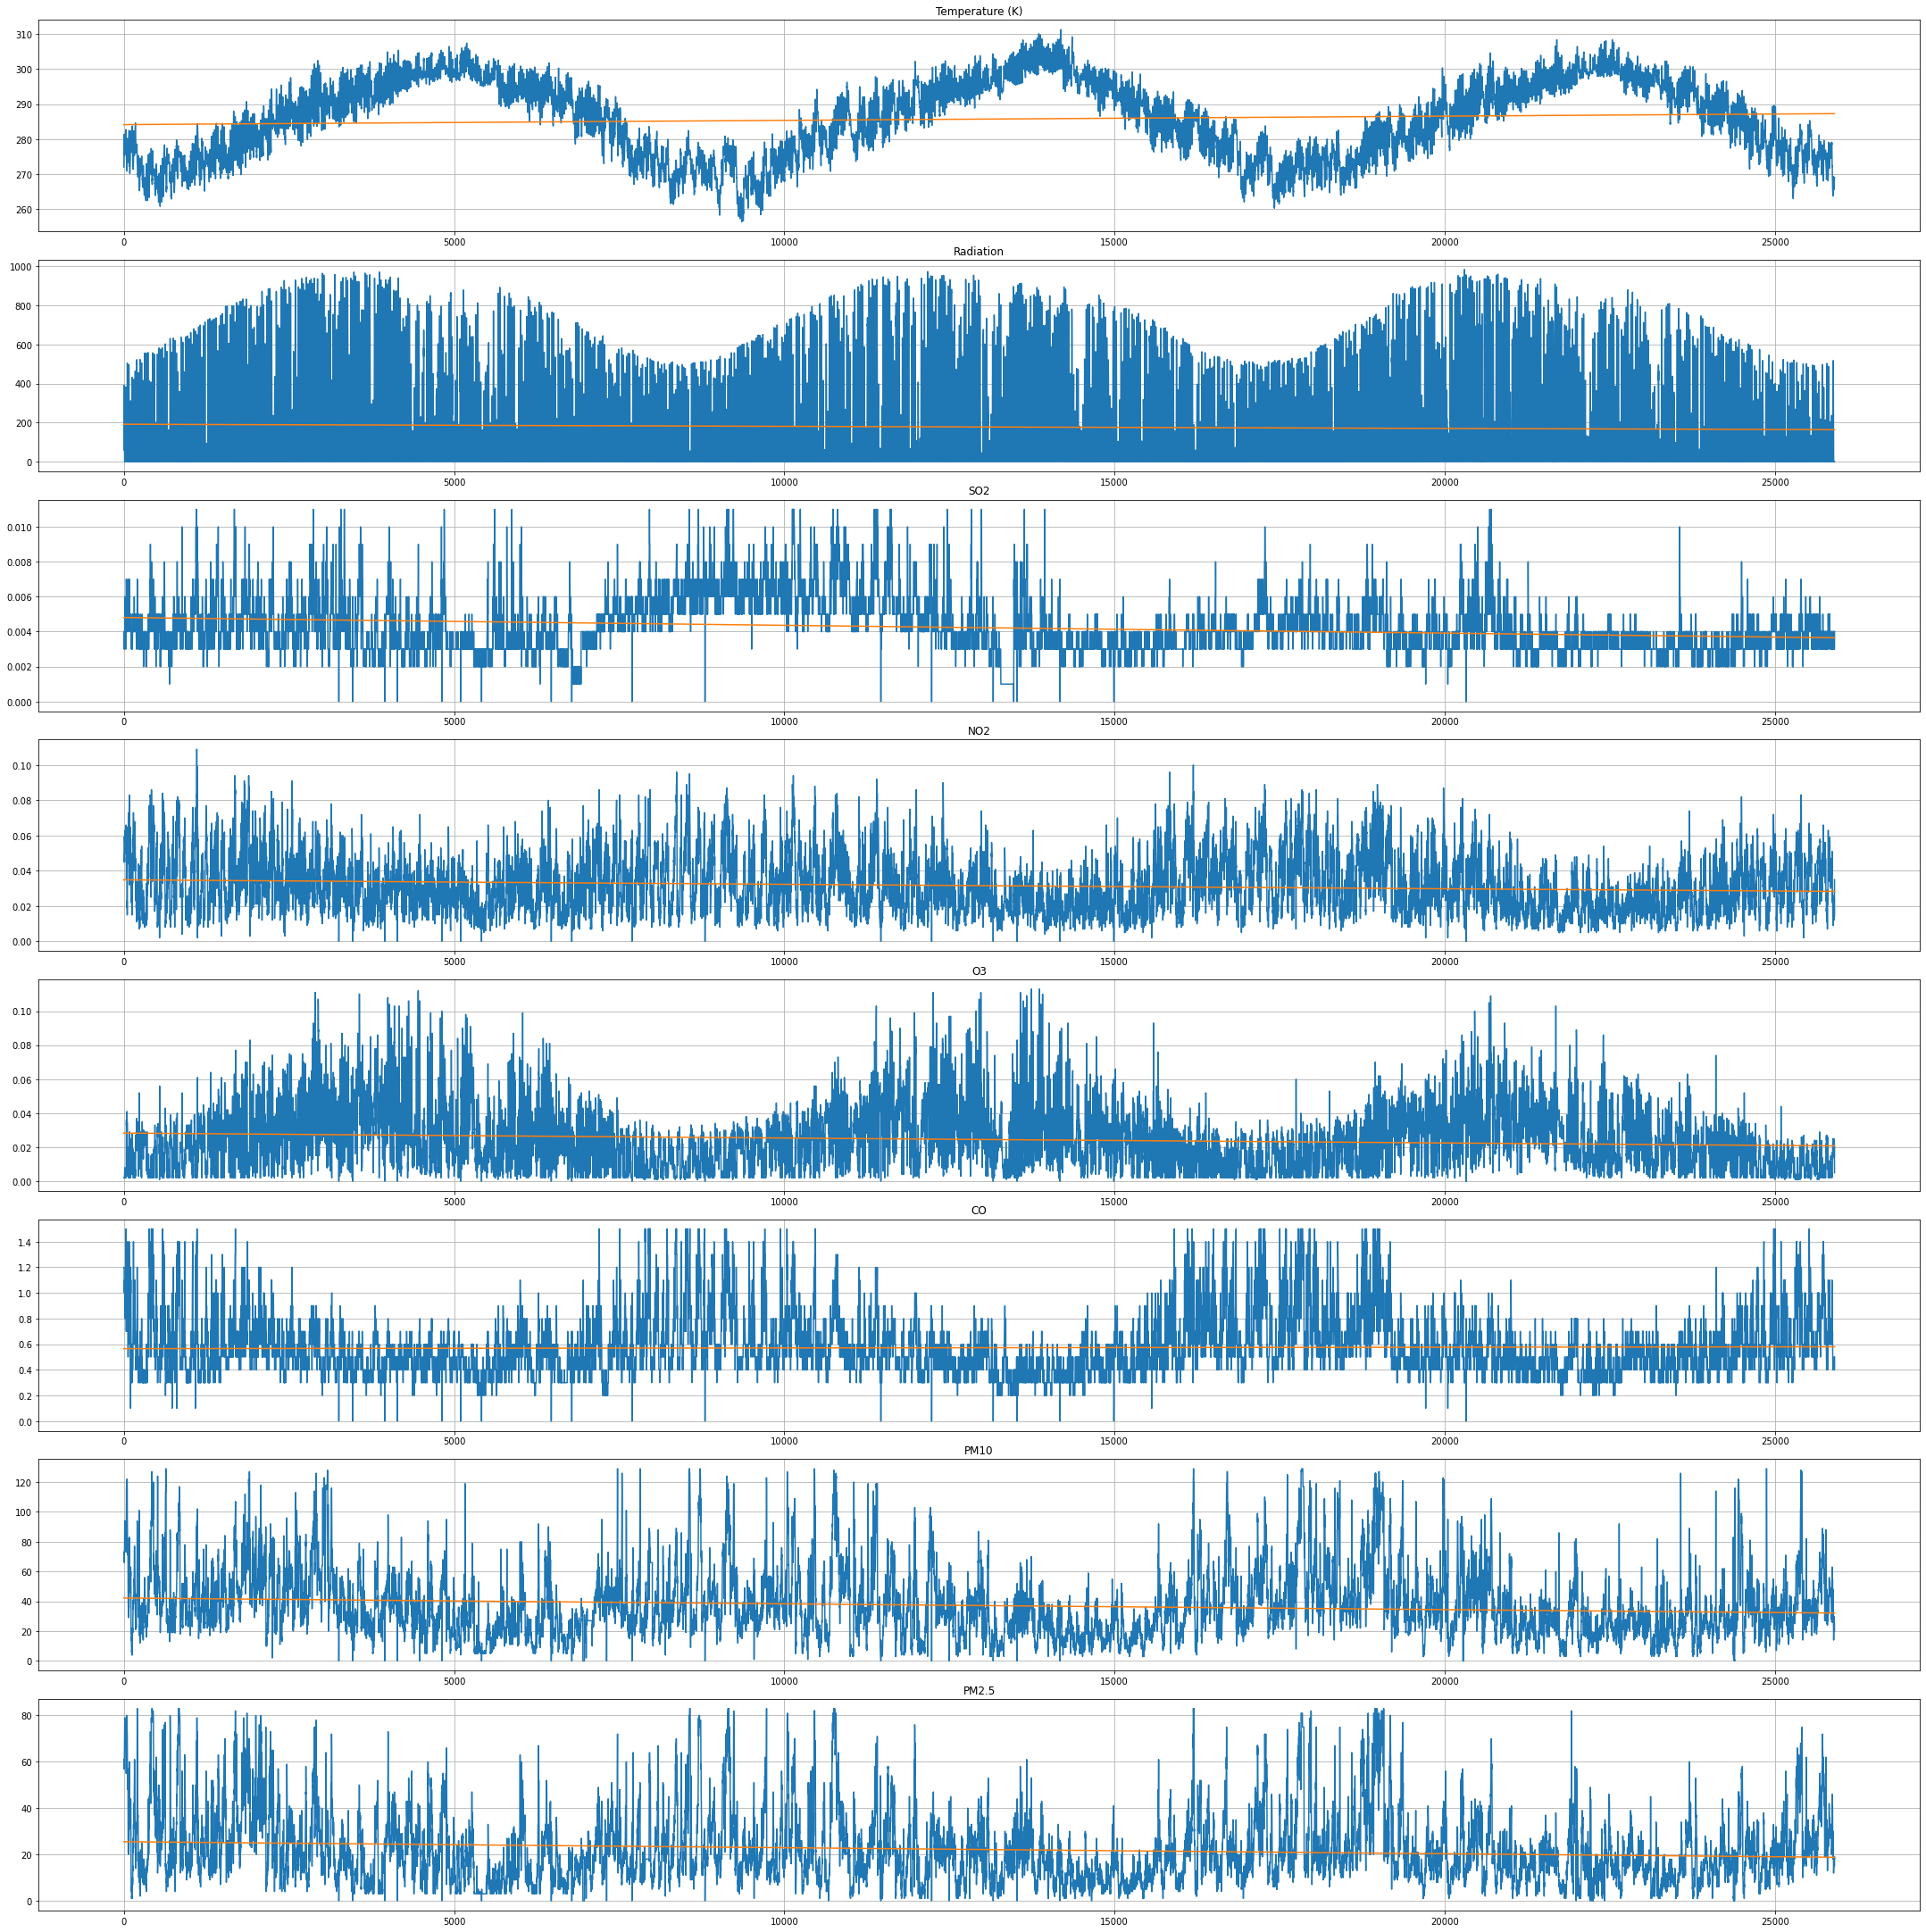

time: 1.13 s


In [5]:
fig, axs = plt.subplots(8,1, figsize = (30, 30))
fig.tight_layout()

for idx, item in enumerate(components):
    model = sm.OLS(df[item], sm.add_constant(df.index))
    beta = model.fit().params ; print(f"\n{item} parameters:\n", beta)
    print("Regression Start: ", beta["const"] + (beta["x1"] * df.index.min()), "\nRegression End: ",  beta["const"] + (beta["x1"] * df.index.max()))
    axs[idx].plot(df[item]); plt.grid()
    axs[idx].plot(beta["const"] + (beta["x1"] * df.index))
    axs[idx].set_title(item); axs[idx].grid()

From the values predicted by the regression models at the start and end of the time series, we can see that most are rather significant even though their slopes seem insignifcant. The linear regression for temperatures shows a 3 degree Kelvin increase over the three year time span. Radiation shows an extremem difference with a decrease of 30 W/m^2. Some of the air pollutants shows changes in concentration of around 50%. Some things that must be heavily considered:
- We are using a relatively short time series in a single location
- There could be end-point discontinuities (cycle ends abruptly without matching the point in the cycle it was at at the beginning of the time series. This is a concern when we do our fourier transform - we can use windowing to reduce spectral leakage)
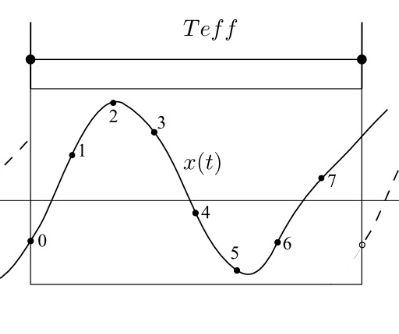
- Linear Regressions are obviously not the best method to use for sinusoidal time series data, we can try LOWESS and Fourier Transforms to get better fits

In [6]:
'''
# NOTE: this cell's runtime is ~ 4 minutes because it is running 24 LOWESS regressions
fig, axs = plt.subplots(24,1, figsize = (30, 30))
fig.tight_layout()

# determines strength of fit to local points, lower numbers indicate increased strength
frac_list = [0.2, 0.05, 0.01]

counter = 0
for item in components:
    print(f"{item} Regression Values: ")
    for f_val in frac_list:
        # https://www.statsmodels.org/devel/generated/statsmodels.nonparametric.smoothers_lowess.lowess.html
        lowess_model = sm.nonparametric.lowess(df[item], df.index, frac=f_val, return_sorted = False)
        print("Regression Start: ", lowess_model[0], "Regression End: ", lowess_model[-1])
        
        axs[counter].plot(df[item]); plt.grid()
        axs[counter].plot(lowess_model)
        axs[counter].set_title(item); axs[counter].grid()
        
        counter += 1     
'''

'\n# NOTE: this cell\'s runtime is ~ 4 minutes because it is running 24 LOWESS regressions\nfig, axs = plt.subplots(24,1, figsize = (30, 30))\nfig.tight_layout()\n\n# determines strength of fit to local points, lower numbers indicate increased strength\nfrac_list = [0.2, 0.05, 0.01]\n\ncounter = 0\nfor item in components:\n    print(f"{item} Regression Values: ")\n    for f_val in frac_list:\n        # https://www.statsmodels.org/devel/generated/statsmodels.nonparametric.smoothers_lowess.lowess.html\n        lowess_model = sm.nonparametric.lowess(df[item], df.index, frac=f_val, return_sorted = False)\n        print("Regression Start: ", lowess_model[0], "Regression End: ", lowess_model[-1])\n        \n        axs[counter].plot(df[item]); plt.grid()\n        axs[counter].plot(lowess_model)\n        axs[counter].set_title(item); axs[counter].grid()\n        \n        counter += 1     \n'

time: 1 ms


We can add columns on to the dataframe that represent time in a different way. The datetime object is not very accessible for regression, but if we have numerical values for "day of year", "month of year", representing season using one-hot encoders, etc.

In [7]:
# df["Day of Year"] = df["Time"].dt.day
df["Time"] = pd.to_datetime(df["Time"])
df["Day of Month"] = df["Time"].dt.day
df["Day of Year"] = df["Time"].dt.dayofyear
df["Month of Year"] = df["Time"].dt.month
df["Season (Num)"] = df["Month of Year"]%12 // 3 + 1
df["Winter"] = 1*(df["Season (Num)"] == 1)
df["Spring"] = 1*(df["Season (Num)"] == 2)
df["Summer"] = 1*(df["Season (Num)"] == 3)
df["Fall"] = 1*(df["Season (Num)"] == 4)
df.drop('Season (Num)', axis=1, inplace=True)
df

,Time,Temperature (K),Radiation,SO2,NO2,O3,CO,PM10,PM2.5,Day of Month,Day of Year,Month of Year,Winter,Spring,Summer,Fall
0,2017-01-01 00:00:00,272.00818,61.362255,0.004,0.059,0.002,1.2,73.0,57.0,1,1,1,1,0,0,0
1,2017-01-01 01:00:00,272.25480,171.832320,0.004,0.058,0.002,1.2,71.0,59.0,1,1,1,1,0,0,0
2,2017-01-01 02:00:00,277.65262,299.281650,0.004,0.056,0.002,1.2,70.0,59.0,1,1,1,1,0,0,0
3,2017-01-01 03:00:00,278.54010,390.387570,0.004,0.056,0.002,1.2,70.0,58.0,1,1,1,1,0,0,0
4,2017-01-01 04:00:00,278.69528,378.793100,0.003,0.051,0.002,1.2,69.0,61.0,1,1,1,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25900,2019-12-31 19:00:00,267.61273,0.000000,0.003,0.026,0.014,0.5,26.0,19.0,31,365,12,1,0,0,0
25901,2019-12-31 20:00:00,268.24185,0.000000,0.003,0.024,0.014,0.4,27.0,19.0,31,365,12,1,0,0,0
25902,2019-12-31 21:00:00,268.46835,0.000000,0.003,0.014,0.021,0.4,23.0,18.0,31,365,12,1,0,0,0
25903,2019-12-31 22:00:00,268.89783,0.000000,0.003,0.022,0.014,0.5,20.0,19.0,31,365,12,1,0,0,0


time: 36 ms


### Correlations 
Which variables are most strongly covariated over the length of our time series?

In [8]:
corrs = df[['Temperature (K)', 'Radiation', 'SO2', 'NO2', 'O3', 'CO', 'PM10', 'PM2.5']].corr()
corrs

,Temperature (K),Radiation,SO2,NO2,O3,CO,PM10,PM2.5
Temperature (K),1.000000,0.327442,-0.323313,-0.219107,0.211692,-0.341276,-0.285083,-0.237646
Radiation,0.327442,1.000000,-0.115766,-0.052408,-0.204180,-0.029784,-0.052320,-0.032402
SO2,-0.323313,-0.115766,1.000000,0.415373,0.073214,0.413599,0.507411,0.479769
NO2,-0.219107,-0.052408,0.415373,1.000000,-0.455648,0.817397,0.505798,0.559960
O3,0.211692,-0.204180,0.073214,-0.455648,1.000000,-0.400581,0.022536,-0.032469
CO,-0.341276,-0.029784,0.413599,0.817397,-0.400581,1.000000,0.601267,0.678054
PM10,-0.285083,-0.052320,0.507411,0.505798,0.022536,0.601267,1.000000,0.864130
PM2.5,-0.237646,-0.032402,0.479769,0.559960,-0.032469,0.678054,0.864130,1.000000


time: 14 ms


[Text(0.5, 1.0, 'Air Pollutant Correlations')]

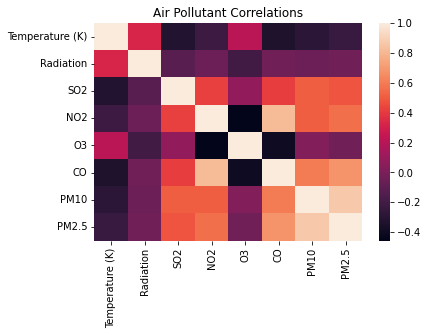

time: 124 ms


In [9]:
sns.heatmap(corrs).set(title='Air Pollutant Correlations')

In [10]:
for item in components:
    print(f"\n{item} Correlations:\n", corrs[item].sort_values(ascending=False))


Temperature (K) Correlations:
 Temperature (K)    1.000000
Radiation          0.327442
O3                 0.211692
NO2               -0.219107
PM2.5             -0.237646
PM10              -0.285083
SO2               -0.323313
CO                -0.341276
Name: Temperature (K), dtype: float64

Radiation Correlations:
 Radiation          1.000000
Temperature (K)    0.327442
CO                -0.029784
PM2.5             -0.032402
PM10              -0.052320
NO2               -0.052408
SO2               -0.115766
O3                -0.204180
Name: Radiation, dtype: float64

SO2 Correlations:
 SO2                1.000000
PM10               0.507411
PM2.5              0.479769
NO2                0.415373
CO                 0.413599
O3                 0.073214
Radiation         -0.115766
Temperature (K)   -0.323313
Name: SO2, dtype: float64

NO2 Correlations:
 NO2                1.000000
CO                 0.817397
PM2.5              0.559960
PM10               0.505798
SO2                0.4

### Fourier Analysis & Transform
What frequencies are the most important when fitting sinusoids to the air pollution time series? We can then use these these time scales for [min, max, mean] relationships between variables. These time scales could also be useful in figuring out how to cluster our data. 

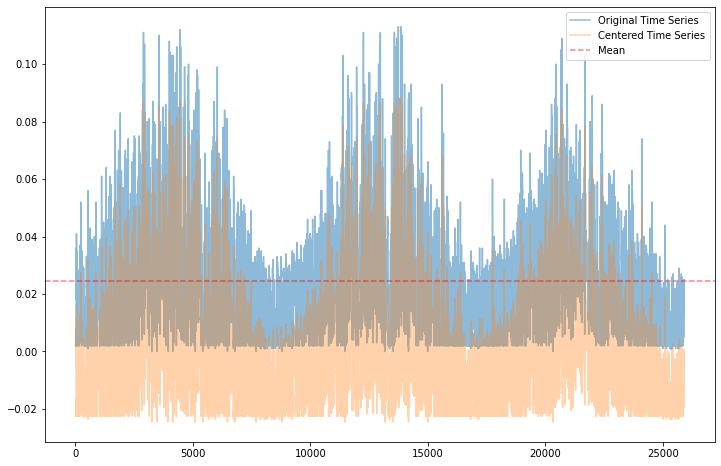

time: 242 ms


In [11]:
# Need to detrend the data in order to obtain actual frequencies
df_idx = df.reset_index()
X = df_idx[["index"]].to_numpy()
centered_o3 = df["O3"].values - df["O3"].mean()

plt.figure(figsize=(12,8))
plt.plot(df["O3"], alpha=0.5, label="Original Time Series")
plt.plot(centered_o3, alpha=0.35, label="Centered Time Series")
plt.axhline(y=df["O3"].mean(), color='red', linestyle='--', label="Mean", alpha=0.5)
plt.legend()

Text(153.0, 0.5, 'Concentration')

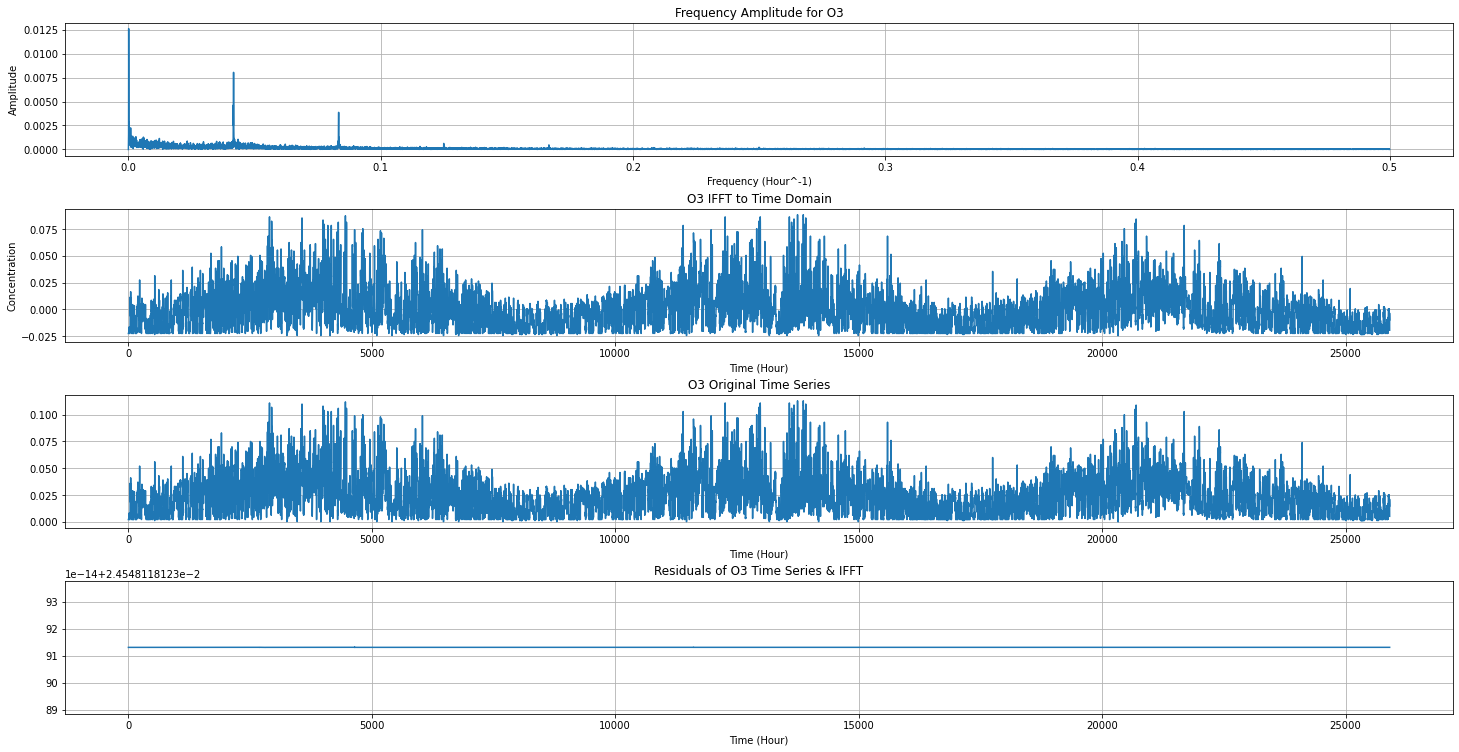

time: 330 ms


In [12]:
# need to specify length of time (N) and sampling frequency (dt)
N = len(df)
dt = 1 # hourly

# FFT
o3_freq = fft(centered_o3)
o3_hour = fftfreq(N, dt)
o3_ifft = ifft(o3_freq)

fig, axs = plt.subplots(4,1, figsize = (20, 12))
fig.tight_layout()

# set the spacing between subplots
plt.subplots_adjust(bottom=0.2, 
                    top=1, 
                    wspace=0.4, 
                    hspace=0.4)

# O3 Frequency Domain
axs[0].plot(o3_hour[0:N//2], 2.0/N * np.abs(o3_freq[0:N//2])); plt.grid()
axs[0].set_title("Frequency Amplitude for O3"); axs[0].grid()
axs[0].set_xlabel("Frequency (Hour^-1)"); axs[0].set_ylabel("Amplitude")

# O3 IFFT to Time Domain
axs[1].plot(o3_ifft); plt.grid()
axs[1].set_title("O3 IFFT to Time Domain"); axs[1].grid()
axs[1].set_xlabel("Time (Hour)"); axs[1].set_ylabel("Concentration")

# O3 Original Time Series
axs[2].plot(df["O3"]); plt.grid()
axs[2].set_title("O3 Original Time Series"); axs[2].grid()
axs[2].set_xlabel("Time (Hour)"); axs[1].set_ylabel("Concentration")

# Residuals between IFFT and Original Time Series
o3_residuals = df["O3"] - o3_ifft
axs[3].plot(o3_residuals); plt.grid()
axs[3].set_title("Residuals of O3 Time Series & IFFT"); axs[3].grid()
axs[3].set_xlabel("Time (Hour)"); axs[1].set_ylabel("Concentration")

In [13]:
# there are 5 noticeable peaks in the frequency spectrum
max_indices = np.argpartition(2.0/N * np.abs(o3_freq[0:N//2]), -5)[-5:]

for idx in max_indices[::-1]:
    print("\nFrequencies of Highest Amplitude: ", o3_hour[idx],
         "\nLength of Hour Cycle: ", 1/o3_hour[idx], 
         "\nCycle in Days: ", (1/o3_hour[idx])/24, 
         "\nAmplitude: ", 2.0/N * np.abs(o3_freq[idx]))


Frequencies of Highest Amplitude:  0.00011580775911986103 
Length of Hour Cycle:  8635.0 
Cycle in Days:  359.7916666666667 
Amplitude:  0.012595595243823358

Frequencies of Highest Amplitude:  0.04169079328314997 
Length of Hour Cycle:  23.98611111111111 
Cycle in Days:  0.9994212962962963 
Amplitude:  0.00803802025982488

Frequencies of Highest Amplitude:  0.041652190696776684 
Length of Hour Cycle:  24.008341056533826 
Cycle in Days:  1.0003475440222427 
Amplitude:  0.005345294266125753

Frequencies of Highest Amplitude:  0.04157498552403011 
Length of Hour Cycle:  24.05292479108635 
Cycle in Days:  1.0022051996285979 
Amplitude:  0.004624596903646487

Frequencies of Highest Amplitude:  0.08334298397992665 
Length of Hour Cycle:  11.998610467809172 
Cycle in Days:  0.49994210282538215 
Amplitude:  0.0038703724872687886
time: 3 ms


The residuals are ridiculously low, so we can be assured that the frequencies pulled out by the FFT are accurate. Removing the trend from the data reduces the amplitude at frequency 0. The frequency with the greatest amplitude (by far) is 1/8635, which is equivalent to a cycle length of approximately 359 days. The next few are frequencies with a cycle length of about 1 day. The last appears to be the diurnal cycle (12-hour period), but this frequency has a very weak amplitude. We can use these time frames to inform which features on which time scales we use as predictors in our machine learning model. 

### Windowing to Reduce Spectral Leakage
We can use a "window" to taper out time series near the end points, which will make it periodic. This will give greater weighting to samples in the middle and reduce the resolution of our transformation, but will also reduce undesirable low-frequecy patterns that are a result of discontinuities. 

Text(153.0, 0.5, 'Concentration')

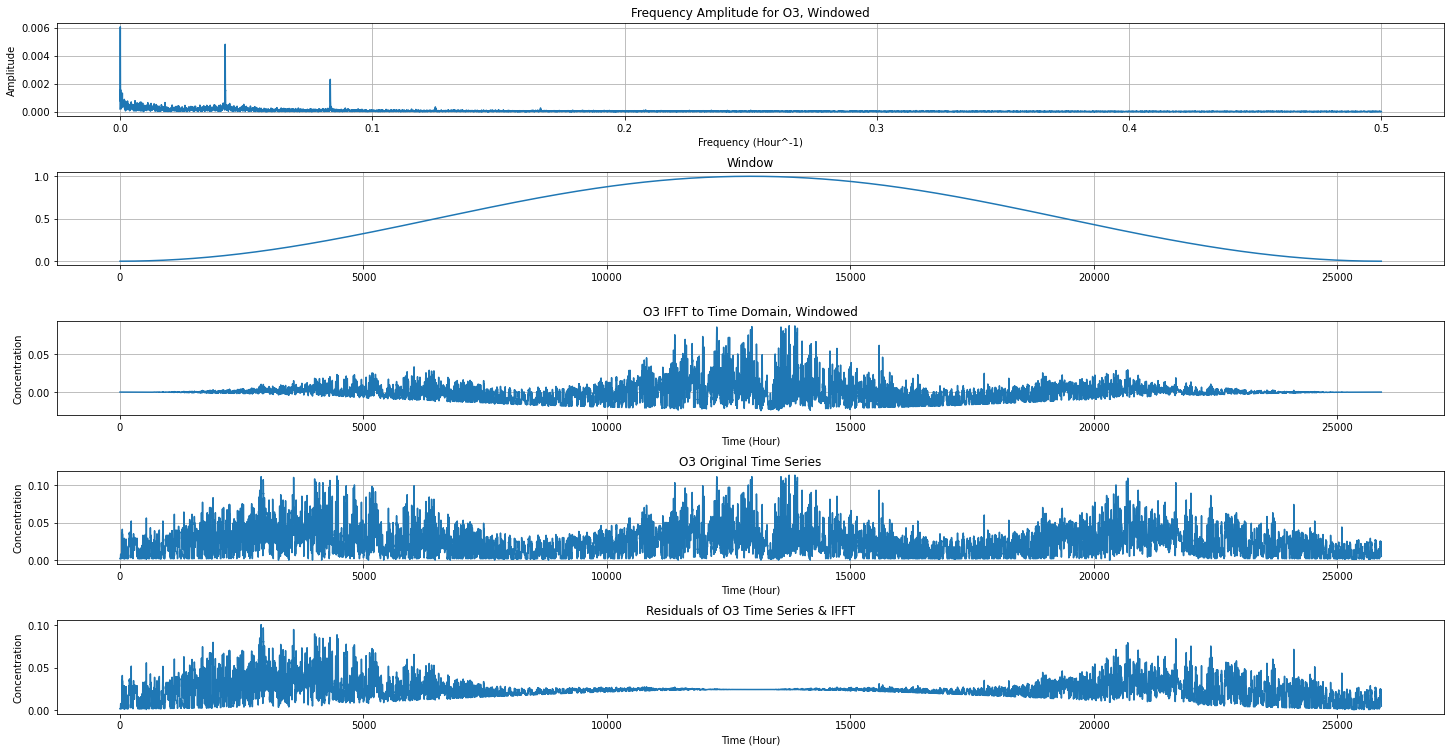

time: 360 ms


In [20]:
from scipy.signal import get_window

w = get_window('hann',N)

# need to specify length of time (N) and sampling frequency (dt)
N = len(df)
dt = 1 # hourly

# FFT
o3_windowed_freq = fft(centered_o3 * w)
o3_windowed_ifft = ifft(o3_windowed_freq)

fig, axs = plt.subplots(5,1, figsize = (20, 12))
fig.tight_layout()

# set the spacing between subplots
plt.subplots_adjust(bottom=0.2, 
                    top=1, 
                    wspace=0.4, 
                    hspace=0.6)

# O3 Frequency Domain
axs[0].plot(o3_hour[0:N//2], 2.0/N * np.abs(o3_windowed_freq[0:N//2])); plt.grid()
axs[0].set_title("Frequency Amplitude for O3, Windowed"); axs[0].grid()
axs[0].set_xlabel("Frequency (Hour^-1)"); axs[0].set_ylabel("Amplitude")

# Window
axs[1].plot(w); plt.grid()
axs[1].set_title("Window"); axs[1].grid()

# O3 IFFT to Time Domain
axs[2].plot(o3_windowed_ifft); plt.grid()
axs[2].set_title("O3 IFFT to Time Domain, Windowed"); axs[2].grid()
axs[2].set_xlabel("Time (Hour)"); axs[2].set_ylabel("Concentration")

# O3 Original Time Series
axs[3].plot(df["O3"]); plt.grid()
axs[3].set_title("O3 Original Time Series"); axs[3].grid()
axs[3].set_xlabel("Time (Hour)"); axs[3].set_ylabel("Concentration")

# Residuals between IFFT and Original Time Series
o3_residuals = df["O3"] - o3_windowed_ifft
axs[4].plot(o3_residuals); plt.grid()
axs[4].set_title("Residuals of O3 Time Series & IFFT"); axs[4].grid()
axs[4].set_xlabel("Time (Hour)"); axs[4].set_ylabel("Concentration")

In [21]:
# there are 5 noticeable peaks in the frequency spectrum
max_indices = np.argpartition(2.0/N * np.abs(o3_windowed_freq[0:N//2]), -5)[-5:]

for idx in max_indices[::-1]:
    print("\nFrequencies of Highest Amplitude: ", o3_hour[idx],
         "\nLength of Hour Cycle: ", 1/o3_hour[idx], 
         "\nCycle in Days: ", (1/o3_hour[idx])/24, 
         "\nAmplitude: ", 2.0/N * np.abs(o3_freq[idx]))


Frequencies of Highest Amplitude:  0.00011580775911986103 
Length of Hour Cycle:  8635.0 
Cycle in Days:  359.7916666666667 
Amplitude:  0.012595595243823358

Frequencies of Highest Amplitude:  0.04169079328314997 
Length of Hour Cycle:  23.98611111111111 
Cycle in Days:  0.9994212962962963 
Amplitude:  0.00803802025982488

Frequencies of Highest Amplitude:  0.041652190696776684 
Length of Hour Cycle:  24.008341056533826 
Cycle in Days:  1.0003475440222427 
Amplitude:  0.005345294266125753

Frequencies of Highest Amplitude:  0.00015441034549314804 
Length of Hour Cycle:  6476.25 
Cycle in Days:  269.84375 
Amplitude:  0.0008362589190787553

Frequencies of Highest Amplitude:  7.720517274657402e-05 
Length of Hour Cycle:  12952.5 
Cycle in Days:  539.6875 
Amplitude:  0.0015574840741970218
time: 3.99 ms


The windowed FFT returns similar frequencies, with the yearly having the greatest amplitude by far. Daily frequencies are the second most important group. The last two frequencies seen, 269 and 539 days, have low magnitudes and do not make intuitive sense. Since these did not show up in the original FFT, we can assume they are products of distortion by windowing. 

### Zero Padding 
The FFT algorithm is most efficient when working with datasets of length 2^n. Zero padding can also increase resolution through increasing the number of frequency bins. 

In [27]:
def next_pow_2(x):
    return 1 if x==0 else 2**(math.ceil(math.log2(x)))

# Use to increase length of dataset
N_padded = next_pow_2(N)
N_padded

32768

time: 2 ms


Text(153.0, 0.5, 'Concentration')

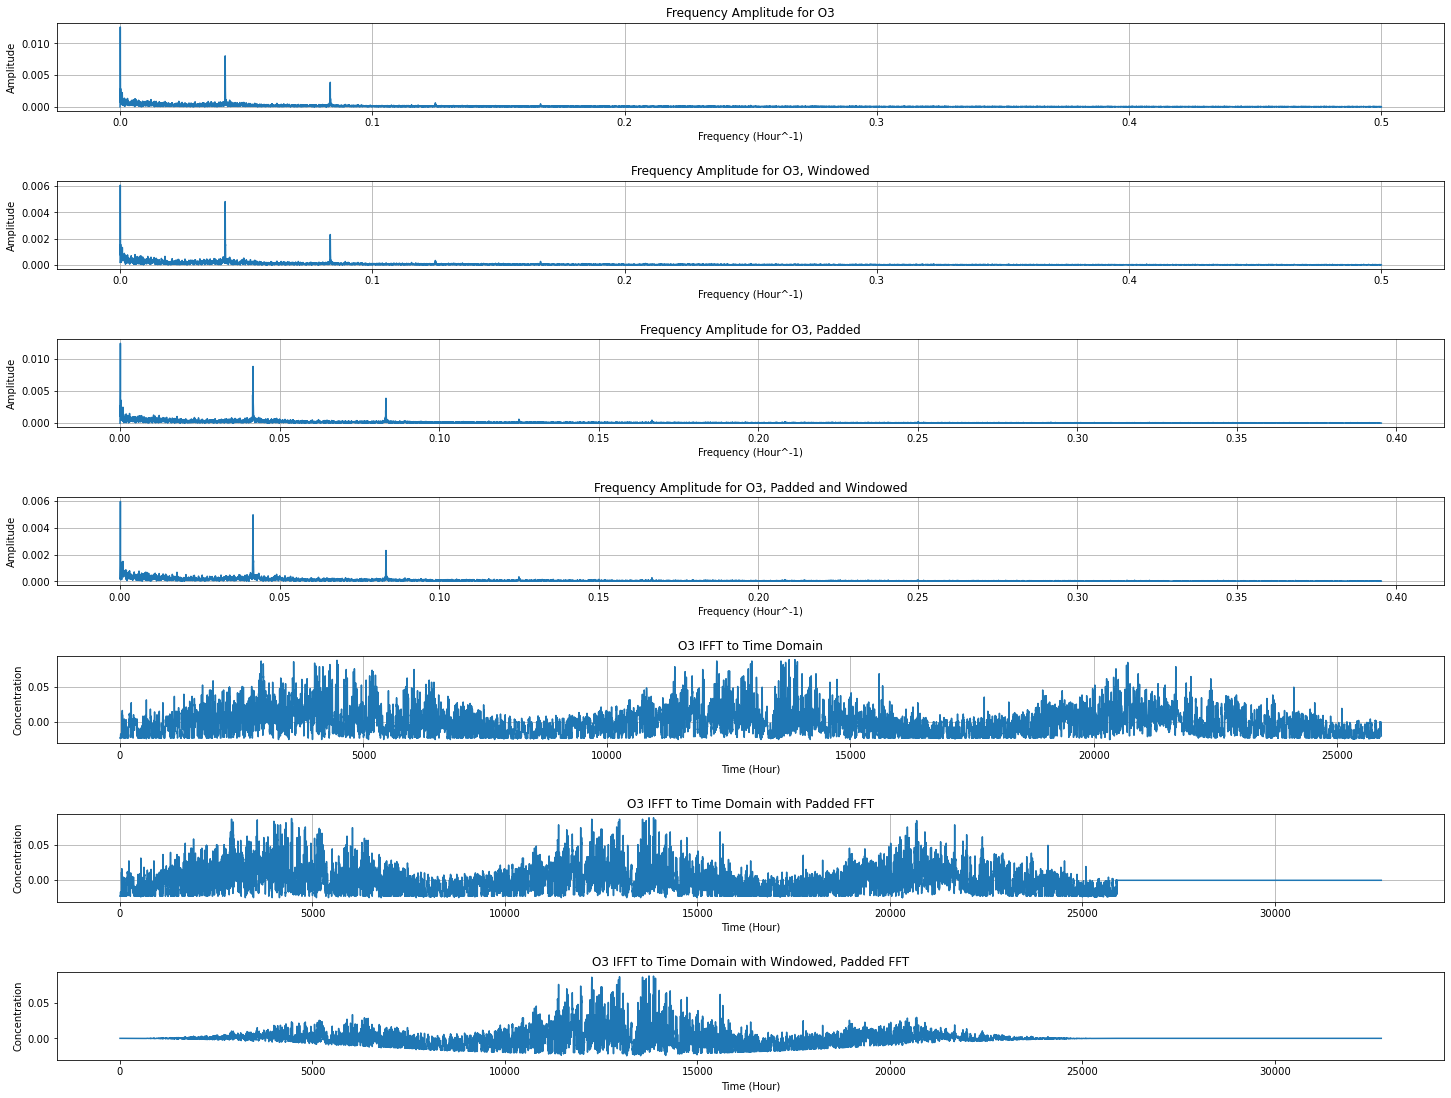

time: 522 ms


In [41]:
# We can use the padded length on both the original and windowed data
o3_padded_freq = fft(centered_o3, N_padded)
o3_padded_windowed_freq = fft(centered_o3 * w, N_padded)
o3_padded_hour = fftfreq(N_padded, dt)
o3_padded_ifft = ifft(o3_padded_freq)
o3_padded_windowed_ifft = ifft(o3_padded_windowed_freq)

fig, axs = plt.subplots(7,1, figsize = (20, 18))
fig.tight_layout()

# set the spacing between subplots
plt.subplots_adjust(bottom=0.2, 
                    top=1, 
                    wspace=0.4, 
                    hspace=0.8)

# O3 Original Frequency Domain
axs[0].plot(o3_hour[0:N//2], 2.0/N * np.abs(o3_freq[0:N//2])); plt.grid()
axs[0].set_title("Frequency Amplitude for O3"); axs[0].grid()
axs[0].set_xlabel("Frequency (Hour^-1)"); axs[0].set_ylabel("Amplitude")

# O3 Windowed Frequency Domain
axs[1].plot(o3_hour[0:N//2], 2.0/N * np.abs(o3_windowed_freq[0:N//2])); plt.grid()
axs[1].set_title("Frequency Amplitude for O3, Windowed"); axs[1].grid()
axs[1].set_xlabel("Frequency (Hour^-1)"); axs[1].set_ylabel("Amplitude")

# O3 Padded Frequency Domain
axs[2].plot(o3_padded_hour[0:N//2], 2.0/N * np.abs(o3_padded_freq[0:N//2])); plt.grid()
axs[2].set_title("Frequency Amplitude for O3, Padded"); axs[2].grid()
axs[2].set_xlabel("Frequency (Hour^-1)"); axs[2].set_ylabel("Amplitude")

# O3 Windowed, Padded Frequency Domain
axs[3].plot(o3_padded_hour[0:N//2], 2.0/N * np.abs(o3_padded_windowed_freq[0:N//2])); plt.grid()
axs[3].set_title("Frequency Amplitude for O3, Padded and Windowed"); axs[3].grid()
axs[3].set_xlabel("Frequency (Hour^-1)"); axs[3].set_ylabel("Amplitude")

# O3 IFFT Original
axs[4].plot(o3_ifft); plt.grid()
axs[4].set_title("O3 IFFT to Time Domain"); axs[4].grid()
axs[4].set_xlabel("Time (Hour)"); axs[4].set_ylabel("Concentration")

# O3 IFFT for Padded
axs[5].plot(o3_padded_ifft); plt.grid()
axs[5].set_title("O3 IFFT to Time Domain with Padded FFT"); axs[5].grid()
axs[5].set_xlabel("Time (Hour)"); axs[5].set_ylabel("Concentration")

# O3 IFFT for Padded, Windowed
axs[6].plot(o3_padded_windowed_ifft); plt.grid()
axs[6].set_title("O3 IFFT to Time Domain with Windowed, Padded FFT"); axs[6].grid()
axs[6].set_xlabel("Time (Hour)"); axs[6].set_ylabel("Concentration")

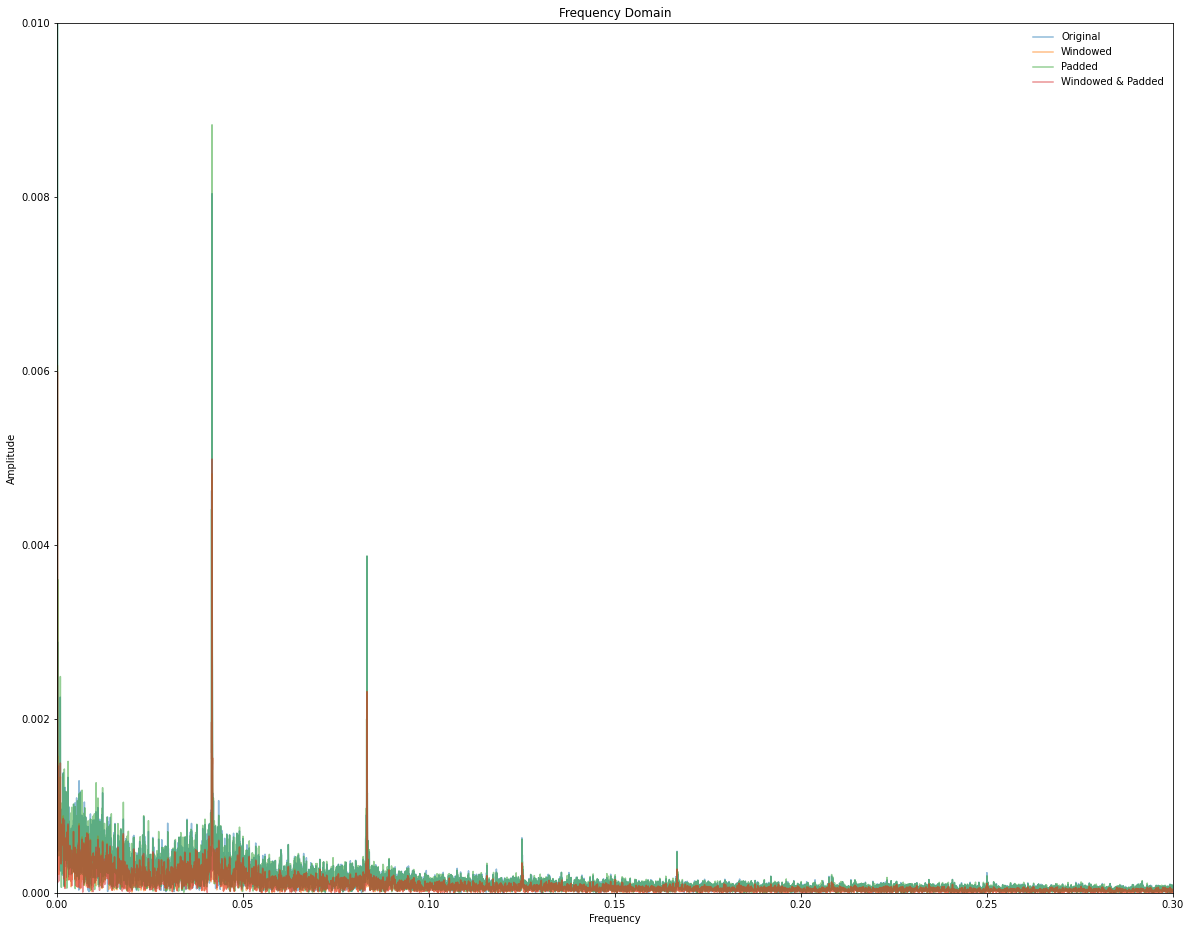

time: 384 ms


In [50]:
plt.figure(figsize=(20,16))
ax = plt.gca()
ax.plot(o3_hour[0:N//2], 2.0/N * np.abs(o3_freq[0:N//2]), label="Original", alpha=0.5)
ax.plot(o3_hour[0:N//2], 2.0/N * np.abs(o3_windowed_freq[0:N//2]), label="Windowed", alpha=0.5)
ax.plot(o3_padded_hour[0:N//2], 2.0/N * np.abs(o3_padded_freq[0:N//2]), label="Padded", alpha=0.5)
ax.plot(o3_padded_hour[0:N//2], 2.0/N * np.abs(o3_padded_windowed_freq[0:N//2]), label="Windowed & Padded", alpha=0.5)
ax.set_title('Frequency Domain')
ax.set_xlabel("Frequency")
ax.set_ylabel("Amplitude")
ax.set_xlim([0,0.3])
ax.set_ylim([0,0.01])
ax.legend(frameon=False)

In [49]:
# there are 5 noticeable peaks in the frequency spectrum
max_indices = np.argpartition(2.0/N * np.abs(o3_padded_freq[0:N//2]), -5)[-5:]

for idx in max_indices[::-1]:
    print("\nFrequencies of Highest Amplitude: ", o3_hour[idx],
         "\nLength of Hour Cycle: ", 1/o3_hour[idx], 
         "\nCycle in Days: ", (1/o3_hour[idx])/24, 
         "\nAmplitude: ", 2.0/N * np.abs(o3_freq[idx]))


Frequencies of Highest Amplitude:  0.00015441034549314804 
Length of Hour Cycle:  6476.25 
Cycle in Days:  269.84375 
Amplitude:  0.0008362589190787553

Frequencies of Highest Amplitude:  0.052731132985910055 
Length of Hour Cycle:  18.964128843338216 
Cycle in Days:  0.7901720351390923 
Amplitude:  0.00026595869054430577

Frequencies of Highest Amplitude:  0.052692530399536766 
Length of Hour Cycle:  18.978021978021978 
Cycle in Days:  0.7907509157509157 
Amplitude:  7.069677520627012e-05

Frequencies of Highest Amplitude:  0.00011580775911986103 
Length of Hour Cycle:  8635.0 
Cycle in Days:  359.7916666666667 
Amplitude:  0.012595595243823358

Frequencies of Highest Amplitude:  0.052576722640416906 
Length of Hour Cycle:  19.019823788546255 
Cycle in Days:  0.7924926578560939 
Amplitude:  0.0003825945076998324
time: 14.7 ms


All methods show the same frequencies dominating, so we can be very confident that the yearly and daily are the most important timeframes.